In [7]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import datetime, timedelta
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools

from scipy.stats import zscore
from pmdarima.arima import arima
from pmdarima.metrics import smape
from pmdarima.model_selection import cross_validate

In [8]:
# Cargar datos y preprocesarlos
tickers = ['BTC-USD']
loader = LoadingData(tickers=tickers)
ts = loader.get_data(start_date='2015-01-01', interval='1mo')
info = loader.get_info_ticker()
ts_tools = tools()
ts = ts_tools.ts_prepartion(ts, 'Date', 'Adj Close')
ts['y'] = np.log(ts['y'].div(ts.groupby('unique_id')['y'].shift(1)))
ts

[*********************100%%**********************]  1 of 1 completed

Getting info for ticker BTC-USD...


,unique_id,ds,y
0,BTC-USD,2024-07-01,NaN
1,BTC-USD,2024-06-01,-0.022722
2,BTC-USD,2024-05-01,0.073985
3,BTC-USD,2024-04-01,-0.107098
4,BTC-USD,2024-03-01,0.162465
...,...,...,...
110,BTC-USD,2015-05-01,-0.133523
111,BTC-USD,2015-04-01,0.025541
112,BTC-USD,2015-03-01,0.033640
113,BTC-USD,2015-02-01,0.040283


In [9]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom_by_client = ts_not_anom.groupby('unique_id')

/var/folders/dt/cxyz36h16ydfv1yg6n6v5fqm0000gn/T/ipykernel_5188/20651149.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)


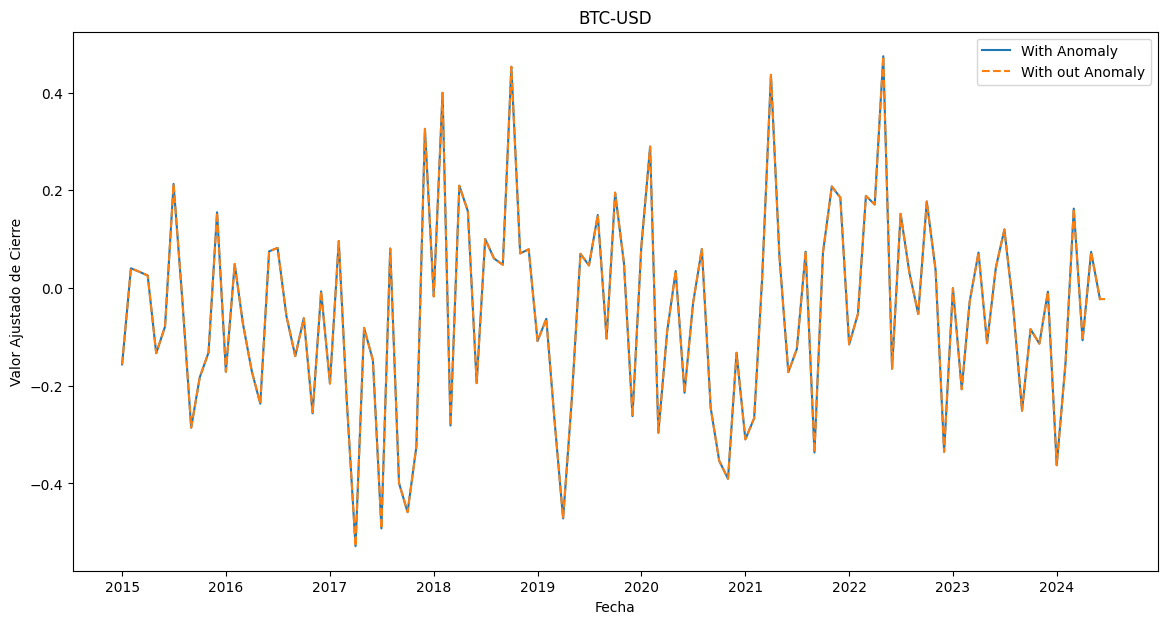

In [10]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = ts.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()

In [11]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para optimizar ARIMA con Optuna
def optimize_ARIMA(trial, ts_ARIMA, training_duration, horizon, cutoffs):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    # Crear y entrenar el modelo ARIMA con los parámetros sugeridos por Optuna
    model = arima(ts_ARIMA, order=(p, d, q))
    model_fit = model.fit()

    # Validación cruzada
    df_cv_model = cross_validate(model_fit, 
                                initial=timedelta(days=training_duration), 
                                horizon=timedelta(days=horizon), 
                                parallel='threads', 
                                cutoffs=cutoffs)
    
    df_metrics = smape(df_cv_model, rolling_window=-1, monthly=True)
    smape_score = df_metrics['smape'].values[0]

    # Retornar la métrica que se desea optimizar (sMAPE en este caso)
    return smape_score

In [13]:
proporcion_entrenamiento = 0.80
horizon_months = 3

def forecast_for_client(id, ts, horizon_months, proporcion_entrenamiento):
    try:
         #Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Horizon para el forecast
        horizon_months = horizon_months
        horizon = horizon_months * 30.5

       # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento)
        ts_entrenamiento = ts[:indice_entrenamiento]
        ts_validacion = ts[indice_entrenamiento:]
        ts_prophet = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo ARIMA
        training_duration = len(ts_entrenamiento) * 30.5
        cutoffs = pd.date_range(start=ts_validacion['ds'].min(), end=ts_validacion['ds'].max() - timedelta(days=horizon), freq='MS')

        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_ARIMA(trial, ts_ARIMA, training_duration, horizon, cutoffs), n_trials=50)

        best_params = study.best_trial.params
        model = arima(order=(best_params['p'], best_params['d'], best_params['q']))
        model_fit = model.fit()

        df_cv_model = cross_validate(model_fit, 
                                initial=timedelta(days=training_duration), 
                                horizon=timedelta(days=horizon), 
                                parallel='threads', 
                                cutoffs=cutoffs)
    
        df_metrics = smape(df_cv_model, rolling_window=-1, monthly=True)
        smape_score = df_metrics['smape'].values[0]

        ### Global Accuracy ###
        last_cutoff = df_cv_model['cutoff'].max()
        df_cv_model_accuracy = df_cv_model[df_cv_model['cutoff'] == last_cutoff]
        total_real = df_cv_model_accuracy['y'].sum()
        total_forecast = df_cv_model_accuracy['yhat'].sum()

        if total_real == 0 and total_forecast == 0:
            smape_global = 0.0
        else:
            smape_global = 2 * np.mean(np.abs(total_real - total_forecast)) / (np.abs(total_real) + np.abs(total_forecast))

        min_smape = min(smape_score, smape_global)
        accuracy_general = round((1 - min_smape / 100), 2) * 100  

        # Pronóstico para el horizonte de predicción
        future = model.make_future_dataframe(periods=horizon_months, freq='MS', include_history=False)
        forecast = model.predict(future)

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy_general,
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')

    except Exception as e:
        print(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None